# install and import

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 9.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
import numpy as np

import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner.tuners import Hyperband
from keras_tuner import Objective
from tensorflow.keras import backend as K

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

# Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PFE/preprocess3FinalBalanced.csv')

In [ ]:
df.shape

(21912, 2)

In [ ]:
df=df.dropna()

In [ ]:
df.text=df.text.astype(str)

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.shape

(21625, 2)

In [ ]:
df.head()

,sentiment,text
0,positive,♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥...
1,positive,رانك هارم دجداد دين مي اعد اد هرام خيي هر قاو ...
2,positive,بار ،هد خير قول جزاير ماش خدامل مشكل كيفاش تصل...
3,positive,ونجور دوك قو سوي ال موقع (المواقع رنس جزائري و...
4,positive,ديد دوله حال زم ماليه الازمه اق عالم شراء شعب ...


In [ ]:
label_mapping = {'positive':2, 'negative':0, 'neutral':1}
df['sentiment'] =[label_mapping[label] for label in df['sentiment']]

In [ ]:
df['sentiment'].value_counts()

0    7302
1    7273
2    7050
Name: sentiment, dtype: int64

# TF-IDF

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=21)

In [ ]:
tfidf = TfidfVectorizer()
x_train = tfidf.fit_transform(x_train)
x_test = tfidf.transform(x_test)

In [ ]:
frequency_matrix=pd.DataFrame(x_train.toarray(),columns=tfidf.get_feature_names_out())
frequency_matrix

,00,0016,02,03,05,0560575166,06,06حپاپ1,06متمسخرش,0772330566,...,ﻭﻗﻠﻴﻞ,ﻭﻟﻮ,ﻭﻟﻴﻦ,ﻭﻣﺎ,ﻳﺆﻣﻨﻮﻥ,ﻳﺠﻬﻠﻮﻥ,ﻳﺴﻤﻌﻮﻥ,ﻳﺸﻜﺮﻭﻥ,ﻳﻌﻘﻠﻮﻥ,ﻳﻌﻠﻤﻮﻥ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## TF-IDF exemple


In [ ]:
documents = ['سعرها مقبول',
                'سعرها غالي']


tf = TfidfVectorizer()
tf.fit(documents)
tf.get_feature_names_out()

array(['سعرها', 'غالي', 'مقبول'], dtype=object)

In [ ]:
doc_array=tf.transform(documents)
doc_array.toarray()

array([[0.57973867, 0.        , 0.81480247],
       [0.57973867, 0.81480247, 0.        ]])

In [ ]:
frequency_matrix=pd.DataFrame(doc_array.toarray(),columns=tf.get_feature_names_out())

In [ ]:
frequency_matrix

,سعرها,غالي,مقبول
0,0.579739,0.000000,0.814802
1,0.579739,0.814802,0.000000


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
tf = CountVectorizer()
tf.fit(documents)
tf.get_feature_names_out()

array(['سعرها', 'غالي', 'مقبول'], dtype=object)

In [ ]:
doc_array=tf.transform(documents)
doc_array.toarray()

array([[1, 0, 1],
       [1, 1, 0]])

In [ ]:
frequency_matrix=pd.DataFrame(doc_array.toarray(),columns=tf.get_feature_names_out())

In [ ]:
frequency_matrix

,سعرها,غالي,مقبول
0,1,0,1
1,1,1,0


# Machine learning

In [ ]:
models=[]
class_names=["negative","neutral","positive"]

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment')

## SVM

In [ ]:
svm = SVC(kernel='linear')
svm.fit(x_train, y_train)
pred=svm.predict(x_test)
print("svm accuracy: ",accuracy_score(y_test, pred))
print("svm f1: ",f1_score(y_test, pred, average='weighted'))

with open('svm.pkl', 'wb') as file:
    pickle.dump(svm, file)

models.append('svm.pkl')

svm accuracy:  0.7482080924855491
svm f1:  0.7495061826547166


In [ ]:
print("svm classification report")
print(classification_report(y_test, pred))

svm classification report
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      1479
           1       0.66      0.70      0.68      1427
           2       0.85      0.76      0.80      1419

    accuracy                           0.75      4325
   macro avg       0.75      0.75      0.75      4325
weighted avg       0.75      0.75      0.75      4325



svm confusion matrix


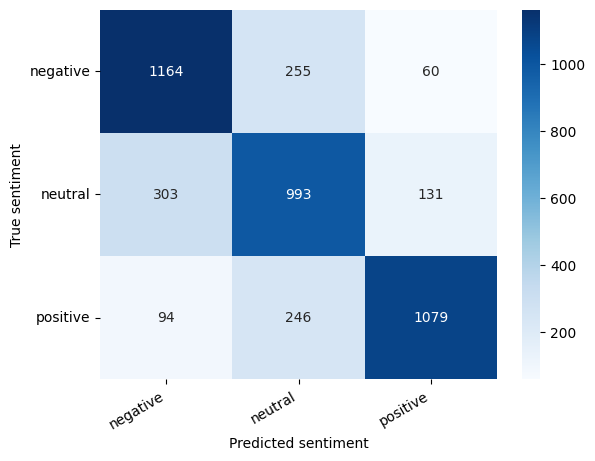

In [ ]:
print("svm confusion matrix")
cm = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## Naive Bayes

In [ ]:
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
pred=mnb.predict(x_test)
print("mnb accuracy: ",accuracy_score(y_test, pred))
print("mnb f1: ",f1_score(y_test, pred, average='weighted'))

with open('mnb.pkl', 'wb') as file:
    pickle.dump(mnb, file)

models.append('mnb.pkl')

mnb accuracy:  0.7347976878612716
mnb f1:  0.7320749957592524


In [ ]:
print("mnb classification report")
print(classification_report(y_test, pred))

mnb classification report
              precision    recall  f1-score   support

           0       0.68      0.86      0.76      1479
           1       0.70      0.58      0.63      1427
           2       0.85      0.76      0.81      1419

    accuracy                           0.73      4325
   macro avg       0.74      0.73      0.73      4325
weighted avg       0.74      0.73      0.73      4325



mnb confusion matrix


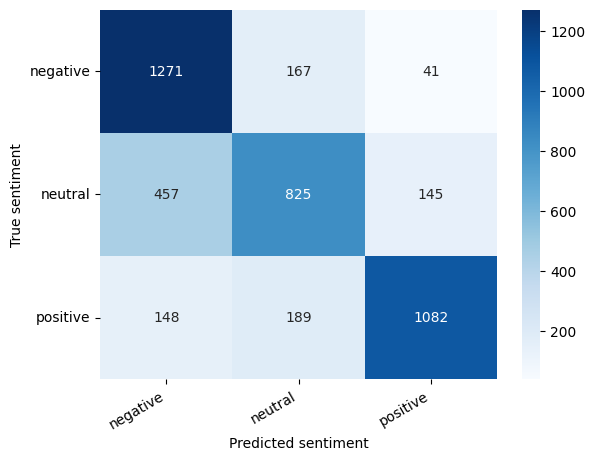

In [ ]:
print("mnb confusion matrix")
cm = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## test Machine Learning



In [ ]:
for model in models:
  print("##########")
  print(" testing with",model)
  with open(model, 'rb') as file:
    loaded_model = pickle.load(file)

    # Perform manual testing
    test_sentences = ["عجبني هايل", "شحال ؟", "ثقل ريزو"]
    test_features = tfidf.transform(test_sentences)
    predicted_labels = loaded_model.predict(test_features)

    # Print the results
    for sentence, label in zip(test_sentences, predicted_labels):
      print(f"Sentence: {sentence}")
      print(f"Predicted label: {label}")
      print("")

##########
 testing with svm.pkl
Sentence: عجبني هايل
Predicted label: 2

Sentence: شحال ؟
Predicted label: 1

Sentence: ثقيل ريزو
Predicted label: 1

##########
 testing with mnb.pkl
Sentence: عجبني هايل
Predicted label: 2

Sentence: شحال ؟
Predicted label: 1

Sentence: ثقيل ريزو
Predicted label: 1



# Deep Learning with three labels

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

In [ ]:
len(tokenizer.word_index) + 1

27510

In [ ]:
max_sequence_length = max([len(sequence) for sequence in sequences])
X = pad_sequences(sequences, maxlen=max_sequence_length)
y = np.array(df.sentiment.values)

In [ ]:
max_sequence_length

265

In [ ]:
y = np.eye(len(label_mapping))[y]
y

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=21)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=21)

In [ ]:
def build_model(hp):
  learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
  dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)

  model = Sequential()
  model.add(Embedding(len(tokenizer.word_index) + 1,
                             output_dim=256,
                             input_length=max_sequence_length))
  model.add(Bidirectional(LSTM(256, dropout=dropout_rate,
                                             recurrent_dropout=dropout_rate,
                                             return_sequences=True)))
  model.add(GlobalMaxPool1D())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(3, activation='softmax'))

  # Compile the model
  optimizer = Adam(learning_rate=learning_rate)

  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=["accuracy"])

  return model

In [ ]:
# Define the Hyperband tuner
tuner = Hyperband(build_model,
                  objective="val_accuracy",
                  max_epochs=3,
                  factor=3,
                  directory='/content/drive/MyDrive/Colab Notebooks/PFE/tfidf_hyper_3',
                  project_name='sentiment_analysis')

In [ ]:
tuner.search(x_train, y_train, validation_data=(x_val, y_val), epochs=15)

In [ ]:
best_hps = tuner.get_best_hyperparameters(1)[0]

In [ ]:
print(best_hps.values)

{'learning_rate': 0.001, 'dropout_rate': 0.1, 'batch_size': 16, 'tuner/epochs': 1, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}


In [ ]:
final_model = tuner.hypermodel.build(best_hps)
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 265, 256)          7042560   
                                                                 
 bidirectional (Bidirectiona  (None, 265, 512)         1050624   
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 512)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history = final_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=15, callbacks=[early_stopping])

Epoch 1/15
406/406 [==============================] - 1062s 3s/step - loss: 0.7181 - accuracy: 0.6826 - val_loss: 0.5834 - val_accuracy: 0.7595
Epoch 2/15
406/406 [==============================] - 1003s 2s/step - loss: 0.3968 - accuracy: 0.8556 - val_loss: 0.6216 - val_accuracy: 0.7644
Epoch 3/15
406/406 [==============================] - 978s 2s/step - loss: 0.2196 - accuracy: 0.9245 - val_loss: 0.8355 - val_accuracy: 0.7461
Epoch 4/15
406/406 [==============================] - 978s 2s/step - loss: 0.1301 - accuracy: 0.9576 - val_loss: 0.8838 - val_accuracy: 0.7360
Epoch 5/15
406/406 [==============================] - 976s 2s/step - loss: 0.0867 - accuracy: 0.9713 - val_loss: 1.0855 - val_accuracy: 0.7140
Epoch 6/15
406/406 [==============================] - 978s 2s/step - loss: 0.0667 - accuracy: 0.9791 - val_loss: 1.4046 - val_accuracy: 0.7135
Epoch 7/15
406/406 [==============================] - 973s 2s/step - loss: 0.0497 - accuracy: 0.9834 - val_loss: 1.2613 - val_accuracy: 0.72

In [ ]:
final_model.save('/content/drive/MyDrive/Colab Notebooks/PFE/bilstm_3.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/PFE/bilstm_3.h5')

In [ ]:
# Evaluate the final model
loss, accuracy = model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

136/136 [==============================] - 34s 218ms/step - loss: 0.6121 - accuracy: 0.7630
Test Loss: 0.61207515001297
Test Accuracy: 0.763005793094635


In [ ]:
pred = model.predict(x_test)

136/136 [==============================] - 20s 146ms/step


In [ ]:
pred = np.argmax(pred, axis=1)

In [ ]:
y_test_original=np.argmax(y_test, axis=1)

In [ ]:
print("deep learning classification report")
print(classification_report(y_test_original, pred))

deep learning classification report
              precision    recall  f1-score   support

           0       0.74      0.88      0.81      1479
           1       0.73      0.62      0.67      1427
           2       0.81      0.79      0.80      1419

    accuracy                           0.76      4325
   macro avg       0.76      0.76      0.76      4325
weighted avg       0.76      0.76      0.76      4325



deep learning confusion matrix


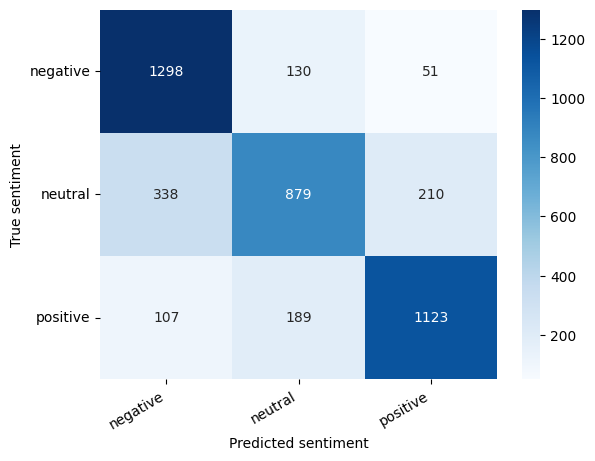

In [ ]:
print("deep learning confusion matrix")
cm = confusion_matrix(y_test_original, pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## Test

In [ ]:
new_texts = ["حرام غال بزاف خل صد ", "شحال دير ؟", "بارك الله فيك"]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_X = pad_sequences(new_sequences, maxlen=max_sequence_length)
predictions = model.predict(new_X)
predicted_labels = np.argmax(predictions, axis=1)
predicted_sentiments = []
for label in predicted_labels:
    sentiment = [key for key, value in label_mapping.items() if value == label][0]
    predicted_sentiments.append(sentiment)
print("Predictions:", predictions)
print("predicted_labels:", predicted_labels)
print('predicted_sentiments:',predicted_sentiments)

1/1 [==============================] - 0s 167ms/step
Predictions: [[0.9592379  0.03322202 0.00754012]
 [0.00434248 0.99033254 0.00532495]
 [0.0073769  0.16732362 0.8252995 ]]
predicted_labels: [0 1 2]
predicted_sentiments: ['negative', 'neutral', 'positive']


# LSTM with two labels

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

In [ ]:
len(tokenizer.word_index) + 1

27510

In [ ]:
max_sequence_length = max([len(sequence) for sequence in sequences])
X = pad_sequences(sequences, maxlen=max_sequence_length)

In [ ]:
max_sequence_length

265

In [ ]:
y = np.array(df.sentiment.values)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [ ]:
x_new = np.empty((0, x_train.shape[1]), x_train.dtype)
y_new = np.empty((0,), y_train.dtype)
for i in range(len(y_train)):
  if y_train[i] != 1:
    #x_train_binary.append(x_train[i])
    x_new = np.vstack((x_new, x_train[i]))
    y_new = np.append(y_new, y_train[i])
    #y_train_binary.append(y_train[i])

In [ ]:
for i in range(len(y_new)):
    if y_new[i] == 2:
        y_new[i] = 1

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_new, y_new, test_size=0.25, random_state=21)

In [ ]:
def build_model(hp):
  learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
  dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)

  model = Sequential()
  model.add(Embedding(len(tokenizer.word_index) + 1,
                             output_dim=256,
                             input_length=max_sequence_length))
  model.add(Bidirectional(LSTM(256, dropout=dropout_rate,
                                             recurrent_dropout=dropout_rate,
                                             return_sequences=True)))
  model.add(GlobalMaxPool1D())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(1, activation='sigmoid'))

  # Compile the model
  optimizer = Adam(learning_rate=learning_rate)

  model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

  return model

In [ ]:
# Define the Hyperband tuner
tuner = Hyperband(build_model,
                  objective='val_accuracy',
                  max_epochs=3,
                  factor=3,
                  directory='/content/drive/MyDrive/Colab Notebooks/PFE/tfidf_hyper_3',
                  project_name='sentiment_analysis')

In [ ]:
#tuner.search(x_train, y_train, validation_data=(x_val, y_val), epochs=15)

In [ ]:
best_hps = tuner.get_best_hyperparameters(1)[0]

In [ ]:
print(best_hps.values)

{'learning_rate': 0.001, 'dropout_rate': 0.1, 'batch_size': 16, 'tuner/epochs': 1, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}


In [ ]:
final_model = tuner.hypermodel.build(best_hps)
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 265, 256)          7042560   
                                                                 
 bidirectional (Bidirectiona  (None, 265, 512)         1050624   
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 512)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history = final_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=15, callbacks=[early_stopping])

Epoch 1/15
269/269 [==============================] - 685s 3s/step - loss: 0.0423 - accuracy: 0.9875 - val_loss: 0.3409 - val_accuracy: 0.9166
Epoch 2/15
269/269 [==============================] - 657s 2s/step - loss: 0.0159 - accuracy: 0.9958 - val_loss: 0.5155 - val_accuracy: 0.9047
Epoch 3/15
269/269 [==============================] - 658s 2s/step - loss: 0.0074 - accuracy: 0.9981 - val_loss: 0.5806 - val_accuracy: 0.9078
Epoch 4/15
269/269 [==============================] - 657s 2s/step - loss: 0.0046 - accuracy: 0.9991 - val_loss: 0.4931 - val_accuracy: 0.9117
Epoch 5/15
269/269 [==============================] - 652s 2s/step - loss: 0.0037 - accuracy: 0.9988 - val_loss: 0.5599 - val_accuracy: 0.9099
Epoch 6/15
269/269 [==============================] - 647s 2s/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.6382 - val_accuracy: 0.9029


In [ ]:
final_model.save('/content/drive/MyDrive/Colab Notebooks/PFE/bilstm_2.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/PFE/bilstm_2.h5')

In [ ]:
predictions = model.predict(x_test)

136/136 [==============================] - 24s 146ms/step


In [ ]:
predicted_labels = []
for prob in predictions:
    if prob < 0.33:
        predicted_labels.append(0)
    elif prob > 0.66:
        predicted_labels.append(2)
    else:
        predicted_labels.append(1)

In [ ]:
predicted_labels

In [ ]:
print("svm accuracy: ",accuracy_score(y_test, predicted_labels))
print("svm f1: ",f1_score(y_test, predicted_labels, average='weighted'))

svm accuracy:  0.6289017341040463
svm f1:  0.5438718928161743


In [ ]:
print("mnb classification report")
print(classification_report(y_test, predicted_labels))

mnb classification report
              precision    recall  f1-score   support

           0       0.61      0.94      0.74      1479
           1       0.67      0.08      0.15      1427
           2       0.65      0.85      0.74      1419

    accuracy                           0.63      4325
   macro avg       0.64      0.63      0.54      4325
weighted avg       0.64      0.63      0.54      4325



mnb confusion matrix


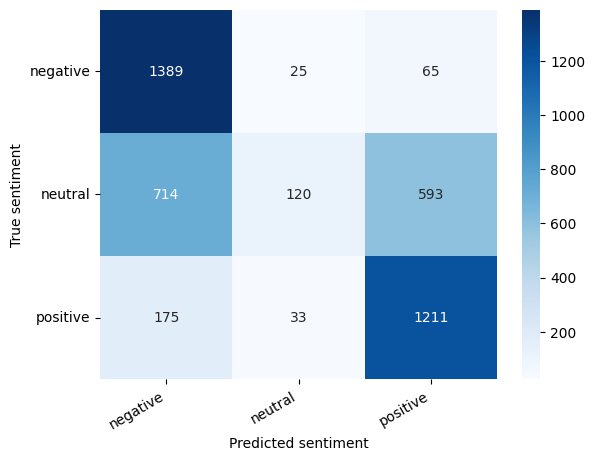

In [ ]:
print("mnb confusion matrix")
cm = confusion_matrix(y_test, predicted_labels)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)